### Setup & Initialization

In [1]:
import os
import sys
import yaml
from contextlib import contextmanager
from datasets import load_dataset
from tqdm.notebook import tqdm
from openai import APIStatusError, RateLimitError, APIConnectionError
from getpass import getpass
import anthropic
import json
import ast
import re
import numpy as np
import time

In [2]:
SAMPLE_SIZE = 50
REPEAT_ANNOTATION = 1

In [27]:
foundaiton_model = "claude-3-opus-20240229"
client = anthropic.Anthropic(
    api_key=getpass("ANTHROPIC API KEY: ")
)

In [4]:
# Specifying path to the necessary files and folders
PATH_TO_SRC = os.path.abspath('../../../')

# Where to get annotation examples for the prompt
ANNOTATION_EXAMPLES_PATH = os.path.join(PATH_TO_SRC, 'src/query/ner_examples_all_languages.json')
CONFIG_PATH = os.path.join(PATH_TO_SRC, "settings/config.yml")
ENV_FILE_PATH = os.path.join(PATH_TO_SRC, '.env')
# Folder to save annotations
RESULTS_PATH = os.path.join(PATH_TO_SRC, 'data/foundation_model_selection/claude3-opus')

In [5]:
@contextmanager
def extend_sys_path(path):
    if path not in sys.path:
        # Append the path to sys.path
        sys.path.append(path)
    try:
        # Execute code inside the 'with' statement
        yield
    finally:
        # Remove the path from sys.path
        if path in sys.path:
            sys.path.remove(path)

In [6]:
# Temporarily add module_path and import functions
with extend_sys_path(PATH_TO_SRC):
    from src.data.sample import sample_for_model_selection
    from src.query.query_gpt import ask_gpt, add_annotation_examples
    from src.query.prompts import MAIN_PROMPT
    from src.utils.utils import calculate_consistency_score

In [8]:
# Reading config file
config = yaml.safe_load(open(os.path.join(PATH_TO_SRC, "settings/config.yml")))

# Load indx-to-label_name mapping
label_mapping = config['label_mapping']
label_mapping

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-DATE',
 8: 'I-DATE'}

### Utils

In [13]:
import time
def ask_gpt_short(
        tokens, language, examples, client, user_prompt,
        max_tokens=1000,
        temperature=0.1,
        model=foundaiton_model,
        system_prompt=None):

    sentence = str(tokens)
    ner_tags = None

    if system_prompt is None:
        system_prompt = f"You are a named entity labelling expert in {language} language."

    # Format user prompt
    user_prompt = user_prompt.format(language=language, sentence=sentence, examples=examples)

    # Save query params
    query_params = {
        'model': model,
        'temperature': temperature,
        'system': system_prompt,
        'messages': [
                        {
                            "role": "user", 
                            "content": [
                                {
                                    "type":"text",
                                    "text":user_prompt
                                }
                            ]
                        }
                     ],
        'max_tokens': max_tokens,
    }

    try:
        # Query the model
        time.sleep(2)
        response = client.messages.create(**query_params)
        # Extract model answer
        answer = response.content[0].text
        return answer

    except APIConnectionError as e:
        raise Exception(f"The server could not be reached: {e.__cause__}")
    except RateLimitError as e:
        raise Exception(f"A 429 status code was received: {e}")
    except APIStatusError as e:
        raise Exception(f"Non-200-range status code received: {e.status_code}, {e.response}")

In [28]:
def repeat_annotation(n_repeat=10, **ask_gpt_kwargs):
    # Counters
    no_json_counter = 0  # No json was provided by the model
    incorrect_format_counter = 0  # Number of records parsed in the incorrect format 

    # Results
    ner_tokens_arr = []

    for i in tqdm(range(n_repeat)):
        # Send request to a model
        model_response = ask_gpt_short(**ask_gpt_kwargs)

        if ask_gpt_kwargs['model'] in ['gpt-4-1106-preview', 'gpt-4-0125-preview',"llama2:70b","llama2","mistral:7b",foundaiton_model]:
            # Newer models provide json
            try:
                ner_tags = json.loads(model_response)['output']
                ner_tokens_arr.append(ner_tags)
            except Exception as e:
                print('#'*80)
                print(e)
                print(model_response)
                incorrect_format_counter += 1
                continue
        else:
            # Extract json only
            match = re.search(r'\{(.*?)\}', model_response)
            if match:
                content = match.group(0)
                # Format output string to parse it as JSON
                try:
                    ner_tags = json.loads(json.dumps(ast.literal_eval(content)))['output']
                    ner_tokens_arr.append(ner_tags)
                except Exception as e:
                    print('#'*80)
                    print(e)
                    print(model_response)
                    incorrect_format_counter += 1
                    continue
            else:
                print('#'*80)
                print('No json found in model\'s response:', model_response)
                no_json_counter += 1
                continue
    print(f'Number of model responses without json: {no_json_counter}')
    print(f'Number of model responses with incorrect formatting: {incorrect_format_counter}')
    return ner_tokens_arr

In [29]:
target_languages= ['tsn','zul','bam',"fon","bbj"]

### Querying all

Language: Fon


  0%|          | 0/3 [00:00<?, ?it/s]

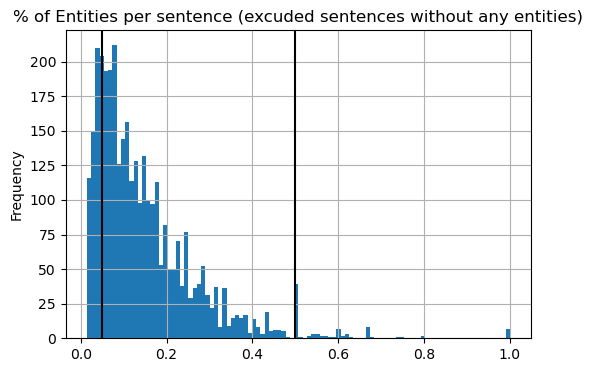

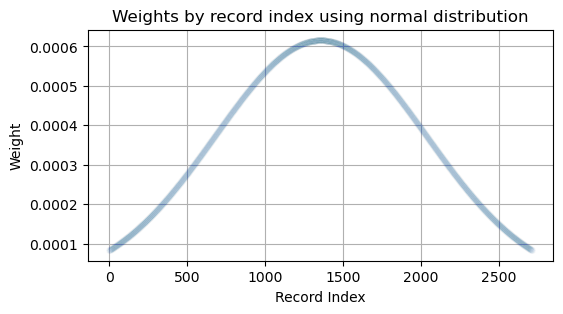

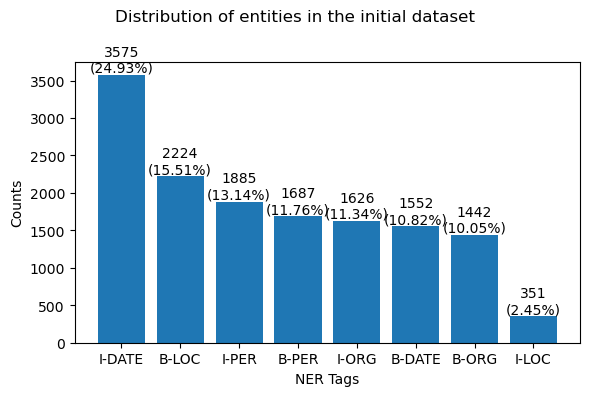

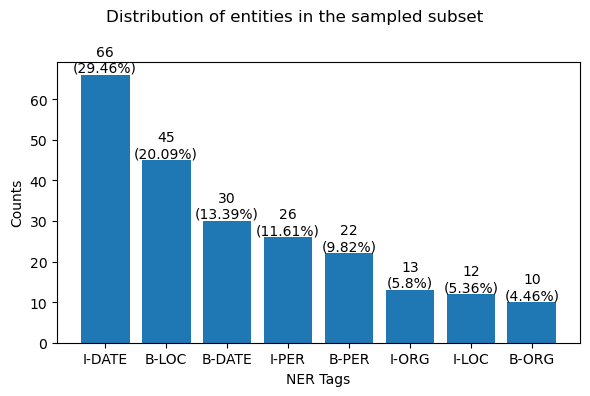

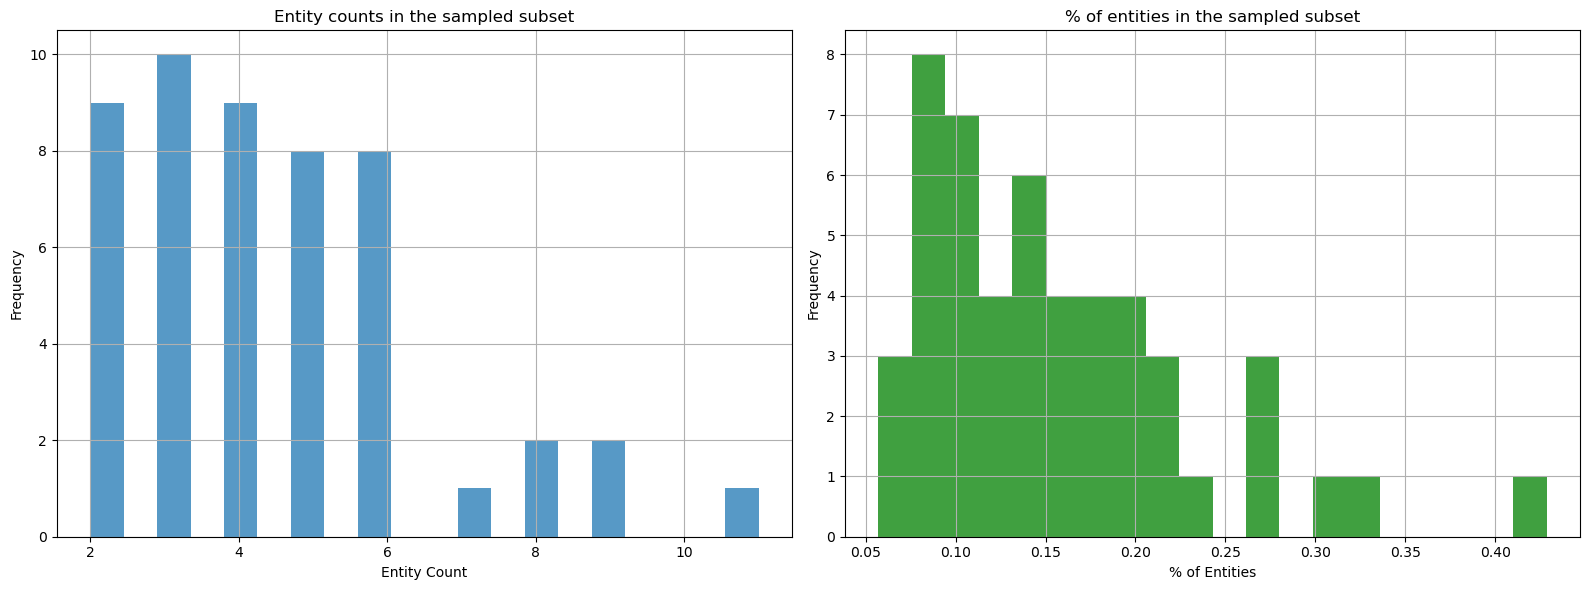


Iteration: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 2


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 3


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 4


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 5


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 6


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 7


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 8


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 9


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 10


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 11


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 12


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 13


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 14


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 15


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 16


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 17


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 18


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 19


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 20


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 21


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 22


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 23


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 24


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 25


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 26


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 27


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 28


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 29


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 30


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 31


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 32


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 33


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 34


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 35


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 36


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 37


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 38


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 39


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 40


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 41


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 42


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 43


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 44


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 45


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 46


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 47


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 48


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 49


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0
Execution time:  987.963917016983 s
Language: Ghomala'


  0%|          | 0/3 [00:00<?, ?it/s]

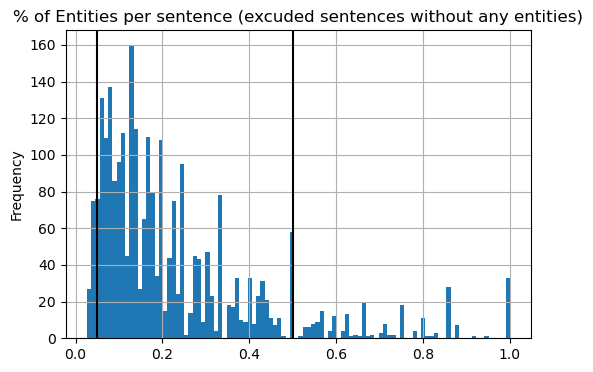

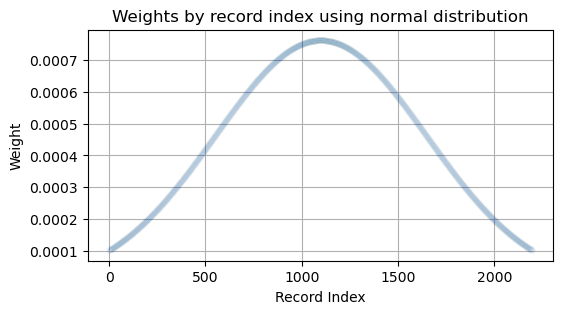

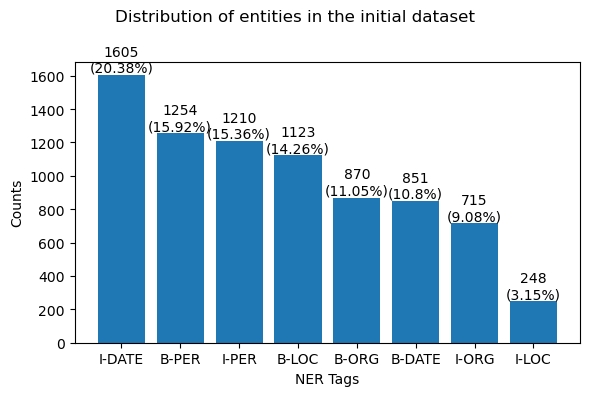

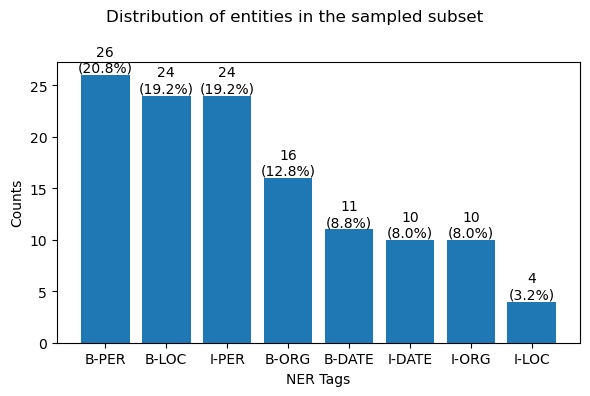

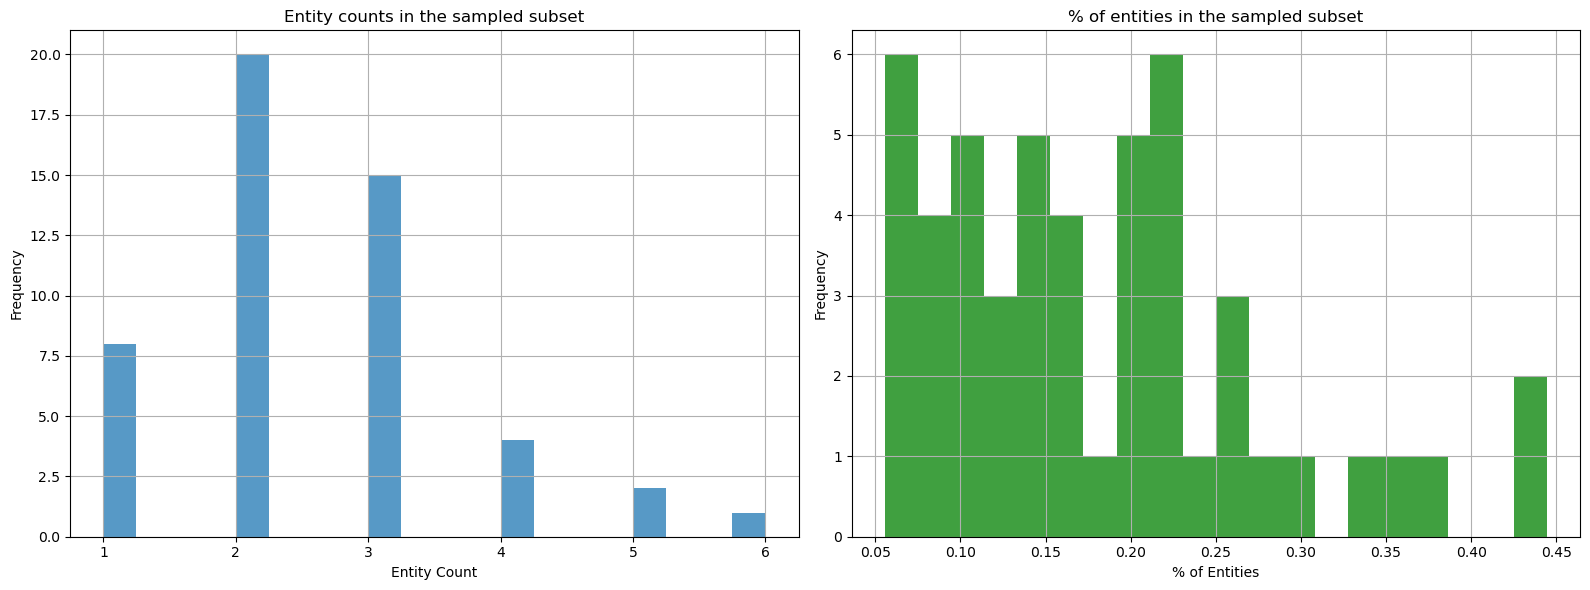


Iteration: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 2


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 3


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 4


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 5


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 1 column 1 (char 0)
Here is the output in JSON format:

{
  "output": [
    ["Pierre", "B-PER"],
    ["Ismaël", "I-PER"], 
    ["Bidoung", "I-PER"],
    ["Mkpatt", "I-PER"],
    ["wə́", "O"],
    ["ŋkhʉɔ́", "O"],
    ["shûʼ", "O"],
    ["shǎʼ", "O"],
    ["31", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 6


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 7


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 8


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 9


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 10


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 1 column 1 (char 0)
Here is the output with named entity labels for the given Ghomala' sentence:

{
  "output": [
    ["A", "O"],
    ["ka", "O"],
    ["púŋ", "O"],
    ["gaə́", "O"],
    ["mo", "O"],
    ["cyə́nyə́", "O"],
    ["dzə̌", "O"],
    ["pú", "O"],
    ["wáp", "O"],
    ["yɔ́", "O"],
    ["ó", "O"],
    ["cwəlǒ", "O"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 11


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 1 column 1 (char 0)
Here is the output with named entity labels:

{
  "output": [
    ["Ŋwâlâʼ", "B-DATE"],
    ["nə̂ntʉɔ", "I-DATE"], 
    ["kə", "O"],
    ["ŋwǎk", "O"],
    ["dyə́", "O"],
    ["gɔ́m", "O"],
    ["páʼ", "O"],
    ["gho", "O"],
    ["lâʼlǎʼ", "O"],
    ["wə́", "O"],
    ["nə́", "O"],
    ["bə́", "O"],
    ["Kaməlûm", "B-LOC"],
    ["lə", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 12


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 13


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 1 column 1 (char 0)
Here is the output in JSON format:

{
  "output": [
    ["Belmondo", "B-PER"],
    ["Arnaud", "I-PER"], 
    ["Bakousso", "I-PER"],
    ["kə̂", "O"],
    ["bə", "O"],
    ["é", "O"],
    ["ê", "O"],
    ["dáʼ", "O"],
    ["míŋ", "O"],
    ["tyə́ʼdzʉ̂", "O"],
    ["é", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 14


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 15


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 1 column 1 (char 0)
Here is the output with named entity labels for the given Ghomala' sentence:

{
  "output": [
    ["A", "O"],
    ["póo", "O"],
    ["dá'tə", "O"],
    ["gaə́", "O"],
    ["mghɛzhí'tə", "O"],
    ["dyə̂kwə̌", "O"],
    ["gɔ", "O"],
    ["pənyə", "O"],
    ["zhí'tə", "O"],
    ["2021", "B-DATE"],
    ["/", "O"],
    ["2022", "B-DATE"],
    ["pəpúŋ", "O"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 16


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 17


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 1 column 1 (char 0)
Here is the output with named entity labels for the given Ghomala' sentence:

{
  "output": [
    ["Kəməlúm", "B-LOC"],
    ["kam", "O"],
    ["mkwíʼtə́", "O"],
    ["dzə̌", "O"],
    ["FÍFÀ", "B-ORG"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 18


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 1 column 1 (char 0)
Here is the output in JSON format:

{
  "output": [
    ["Pô", "O"],
    ["tyə́'", "O"],
    ["ɔ", "O"],
    ["bó", "O"],
    ["shə́ŋ", "O"],
    ["gaə̂", "O"],
    ["guŋ", "O"],
    ["poá", "O"],
    ["Kaməlûn", "B-LOC"],
    ["awɛ́", "O"],
    ["kó", "O"],
    ["zhʉ̂m", "O"],
    ["po", "O"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 19


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 20


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 21


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 22


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 23


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting ',' delimiter: line 10 column 8 (char 162)
{
  "output": [
    ["Taʼ", "O"],
    ["moŋkuŋ", "O"],
    ["Afred", "B-PER"],
    ["Zang", "I-PER"],
    ["gɔm", "O"],
    ["gaə̂", "O"],
    [":", "O"],
    ["""""", "O"],
    ["Gaə̂", "O"],
    ["ŋkuŋ", "O"],
    ["mfaʼ", "O"],
    ["myə̂", "O"],
    ["ba", "O"],
    ["khʉɔ", "O"],
    ["yə", "O"],
    ["â", "O"],
    ["tə́m", "O"],
    ["ntʉ́m", "O"],
    ["pyanyə́", "O"],
    ["zhwop", "O"],
    ["mslow", "O"],
    ["myə́", "O"],
    ["áá", "O"],
    [".", "O"],
    ["""""", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 24


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 25


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 26


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 27


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 1 column 1 (char 0)
Here is the output with named entity labels for the given Ghomala' sentence:

{
  "output": [
    ["Kwípû", "B-DATE"],
    ["dyə̂pəpəŋthə́", "I-DATE"], 
    ["lâlǎʼ", "O"],
    ["pfʉ́", "O"],
    ["jʉm", "O"],
    ["páʼ", "O"],
    ["pú", "O"],
    ["swɔpsyap", "O"],
    ["Kolóna", "B-LOC"],
    ["nə́", "O"],
    ["é", "O"],
    ["lə", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 28


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 1 column 1 (char 0)
Here is the output with named entity labels for the given Ghomala' text:

{
  "output": [
    ["Pə́", "O"],
    ["mkɔ", "O"],
    ["guŋ", "O"],
    ["Kaməlûm", "B-LOC"],
    ["pʉ́ʼtə", "O"],
    ["dəŋ", "O"],
    ["Foʼ", "B-ORG"],
    ["Sê", "I-ORG"],
    ["Guŋ", "I-ORG"],
    ["(", "O"],
    ["FSG", "B-ORG"], 
    [")", "O"],
    ["yɔ́kpə", "O"],
    ["bə́yə", "O"],
    ["pú", "O"],
    ["tɔ́m", "O"],
    ["nwə", "O"],
    ["nə́", "O"],
    ["a", "O"],
    ["pûŋ", "O"],
    ["áá", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 29


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 30


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 1 column 1 (char 0)
Here is the output with named entity labels for the given Ghomala' text:

{
  "output": [
    ["A", "O"],
    ["lə", "O"],
    ["pə̌", "O"],
    ["nə́", "O"],
    ["Dzʉ̂ʼmkǒ", "B-DATE"],
    ["2014", "I-DATE"],
    ["VSS", "B-ORG"],
    ["Tsʉfaʼ", "I-ORG"],
    ["gwyə́", "O"],
    ["lû", "O"],
    ["Yɔ̌", "B-LOC"],
    ["tamʉ́mfɔ́k", "O"],
    ["Mojave", "B-LOC"],
    ["nə́", "O"],
    ["batə", "O"],
    ["55", "O"],
    ["cʉ̌m", "O"],
    ["nə́", "O"],
    ["nə́", "O"],
    ["foʼ", "O"],
    ["nə́", "O"],
    ["tà", "O"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 31


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 32


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 33


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 34


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting ',' delimiter: line 3 column 8 (char 23)
{
  "output": [
    ["""""", "O"],
    ["A", "O"],
    ["tə́", "O"],
    ["bə́", "O"],
    ["pəaŋglofɔ̂nə", "O"],
    ["pə́", "O"],
    ["â", "O"],
    ["bə́", "O"],
    ["pəkamshu", "O"],
    ["fə́", "O"],
    ["m", "O"],
    ["Nizhélyà", "B-LOC"],
    ["""""", "O"],
    ["Vizyɔ́ŋ4", "O"],
    ["""""", "O"],
    ["Pɔ", "O"],
    ["shǎʼ", "O"],
    ["pyə", "O"],
    ["wáp", "O"],
    ["pfʉ́", "O"],
    ["á", "O"],
    ["tə", "O"],
    ["sɔmywə́", "O"],
    ["pə́", "O"],
    ["""""", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 35


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 36


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 37


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 38


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 39


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 40


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 41


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 42


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 43


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 1 column 1 (char 0)
Here is the output with named entity labels for the given Ghomala' sentence:

{
  "output": [
    ["Pə", "O"],
    ["pútə̀", "O"],
    ["lə̂", "O"],
    ["bə́", "O"],
    ["mə́ku'guŋ", "O"],
    ["lâ'lǎ'", "O"],
    ["Edjisna", "B-PER"],
    ["Didier", "I-PER"],
    [".", "O"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero

Iteration: 44


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 45


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 46


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 47


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 48


  0%|          | 0/1 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Iteration: 49


  0%|          | 0/1 [00:00<?, ?it/s]

################################################################################
Expecting value: line 1 column 1 (char 0)
Here is the output with named entity labels:

{
  "output": [
    ["Pə", "O"],
    ["sê", "O"],
    ["mkò", "O"],
    ["zhyə̂nə́", "O"],
    ["nə́", "O"],
    ["kə̂", "O"],
    ["nyaptə", "O"],
    ["kɔŋsɛr", "O"],
    ["valséro", "B-LOC"],
    ["Zenith", "I-LOC"]
  ]
}
Number of model responses without json: 0
Number of model responses with incorrect formatting: 1
division by zero
Execution time:  657.0894539356232 s


In [30]:
for LANGUAGE in target_languages:
    language_name = config['languages_names'][LANGUAGE]
    print("Language:",language_name)
    # Loading dataset from HuggingFace
    data = load_dataset(config['dataset'], LANGUAGE)
    sampled_subset = sample_for_model_selection(data, label_mapping, n_samples=SAMPLE_SIZE, verbose=True)
    sampled_subset
    ask_gpt_params = {
        'language': language_name,
        'examples': add_annotation_examples(ANNOTATION_EXAMPLES_PATH, language_name),
        'client': client,
        'user_prompt': MAIN_PROMPT,
        'model': foundaiton_model ,
        'temperature': 0.1
    }
    gpt_annotations = {}
    consistency_scores = []

    # Measure how much time it takes to get all inferences
    start = time.time()


    for i, record in enumerate(sampled_subset):
        print(f'\nIteration: {i}')
        try: 
            # Extract ground truth
            ground_truth_labels = [label_mapping[t] for t in record['ner_tags']]
            
            # Extract tokens from current record
            ask_gpt_params['tokens'] = record['tokens']
            # Query the model
            new_labels_gpt4 = repeat_annotation(n_repeat=REPEAT_ANNOTATION, **ask_gpt_params)
            # Save annotations
            gpt_annotations[f'record_{i}'] = {}
            gpt_annotations[f'record_{i}']['pred'] = new_labels_gpt4
            gpt_annotations[f'record_{i}']['true'] = ground_truth_labels
            gpt_annotations[f'record_{i}']['tokens'] = record['tokens']
            
            # Calculate consistency score
            consistency = calculate_consistency_score(new_labels_gpt4, ground_truth_labels)
            gpt_annotations[f'record_{i}']['consistency'] = consistency
            consistency_scores.append(consistency)
            
        except Exception as e:
            print(e)
            continue

    # Overall consistency is calculated by averaging individual scores
    gpt_annotations['overall_consistency'] = np.mean(consistency_scores)

    end = time.time()
    print('Execution time: ', end - start, 's')
    with open(os.path.join(RESULTS_PATH, f'{LANGUAGE}.json'), 'w') as file:
        json.dump(gpt_annotations, file, indent=4)
